# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are three main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding and fetching
2. Matching
3. Storage

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

Note: Make sure that you have PostgreSQL running.

## Imports

In [192]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import matplotlib.pyplot as plt
from shapely.wkt import dumps, loads
from pathlib import Path

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)

Created fresh logs/sid_2025-02-26_21-46-31_timing_results.csv
Created fresh logs/sid_2025-02-26_21-46-31_timing.log


<module 'helpers' from '/Users/sra/files/projects/matching_optimization/helpers.py'>

## Generate Test Data

In [193]:
# Create two months of blob data
prev_month_blobs = h.generate_random_polygons(n=10000)
curr_month_blobs = h.generate_random_polygons(n=10000)

Function `generate_random_polygons` executed in 0.1431 sec, CPU: 20.60%, Memory: 11.61MB
Function `generate_random_polygons` executed in 0.1205 sec, CPU: 20.20%, Memory: 0.31MB


In [194]:
prev_month_blobs.head()

,geometry,id
0,"POLYGON ((-67.77737 59.48422, -67.77737 60.922...",7f4dff84-d1b5-4f2c-bf65-77102679ed3b
1,"POLYGON ((26.42248 9.32281, 26.42248 11.29955,...",38dd1028-22a7-48a8-b549-b2b371a3fd64
2,"POLYGON ((34.53971 -70.83667, 34.53971 -69.101...",e228399c-7167-4951-84b6-6d7b28ef5979
3,"POLYGON ((173.13634 -65.81346, 173.13634 -64.1...",5db7eab1-eb05-4986-986b-e5686d582bea
4,"POLYGON ((135.94789 12.84035, 135.94789 14.170...",624b76ae-a2ac-45d5-b42e-688e897bec9b


In [195]:
curr_month_blobs.head()

,geometry,id
0,"POLYGON ((4.28622 46.11889, 4.28622 47.52923, ...",e09e5f03-4d65-4ac2-baee-0fe57e8f9291
1,"POLYGON ((-173.38761 -68.51772, -173.38761 -66...",1bbbfaac-489f-462a-a855-2cdd7498d016
2,"POLYGON ((-31.44297 15.05155, -31.44297 16.136...",021ecc97-941c-4213-b2c1-d000d8296be8
3,"POLYGON ((61.63457 -29.41362, 61.63457 -27.670...",2e815754-6f99-41ea-a35e-17e78855539a
4,"POLYGON ((109.58164 25.28846, 109.58164 26.892...",7eade105-5c06-49ff-b128-e7213142da05


In [196]:
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

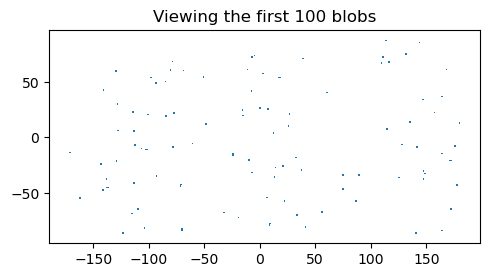

In [197]:
range_ = 100

fig, ax = plt.subplots(figsize=(5, 5))
prev_month_blobs.iloc[0:range_].plot(ax=ax)
ax.set_title(f'Viewing the first {range_} blobs')
plt.tight_layout()

plt.show()

### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [198]:
# copy the gdfs
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [199]:
# Convert WKT versions to strings
dfs_to_convert = [prev_month_blobs_wkt, curr_month_blobs_wkt]
prev_month_blobs_wkt, curr_month_blobs_wkt = [h.convert_col_to_string(df) for df in dfs_to_convert]

# Check result
print(prev_month_blobs_wkt.head())

Function `convert_col_to_string` executed in 0.0471 sec, CPU: 13.50%, Memory: 0.00MB
Function `convert_col_to_string` executed in 0.0461 sec, CPU: 23.70%, Memory: 0.00MB
                                            geometry  \
0  POLYGON ((-67.777368 59.484217, -67.777368 60....   
1  POLYGON ((26.422479 9.322808, 26.422479 11.299...   
2  POLYGON ((34.539713 -70.836672, 34.539713 -69....   
3  POLYGON ((173.136338 -65.813461, 173.136338 -6...   
4  POLYGON ((135.94789 12.840354, 135.94789 14.17...   

                                     id  
0  7f4dff84-d1b5-4f2c-bf65-77102679ed3b  
1  38dd1028-22a7-48a8-b549-b2b371a3fd64  
2  e228399c-7167-4951-84b6-6d7b28ef5979  
3  5db7eab1-eb05-4986-986b-e5686d582bea  
4  624b76ae-a2ac-45d5-b42e-688e897bec9b  


/Users/sra/files/projects/matching_optimization/helpers.py:148: UserWarning: Geometry column does not contain geometry.
  def df_itertuple(df: gpd.GeoDataFrame):
/Users/sra/files/projects/matching_optimization/helpers.py:148: UserWarning: Geometry column does not contain geometry.
  def df_itertuple(df: gpd.GeoDataFrame):


### Save in PostgreSQL database

This is a simple version of what a "non-geospatial-native" data ingestion pipeline may look like, with the primary example being that the polygons are stored as strings, not in a spatial-friendly datatype.

In [200]:
# Convert to tuples
prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0019 sec, CPU: 0.00%, Memory: 0.00MB
Function `df_itertuple` executed in 0.0012 sec, CPU: 0.00%, Memory: 0.00MB


Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [201]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0308 sec, CPU: 0.00%, Memory: 0.00MB


Create and insert into tables:

In [202]:
h.create_pg_table(table_name='prev_blobs_wkt', data=prev_month_blobs_wkt, truncate=True)
h.create_pg_table(table_name='curr_blobs_wkt', data=curr_month_blobs_wkt, truncate=True)

Table prev_blobs_wkt truncated.
Inserted 10000 records into prev_blobs_wkt.
Function `create_pg_table` executed in 0.3939 sec, CPU: 0.00%, Memory: 0.00MB
Table curr_blobs_wkt truncated.
Inserted 10000 records into curr_blobs_wkt.
Function `create_pg_table` executed in 0.4047 sec, CPU: 41.30%, Memory: 126.31MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [203]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0471 sec, CPU: 29.40%, Memory: 0.00MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0404 sec, CPU: 9.00%, Memory: 0.00MB


In [204]:
df_prev.head()

,geometry,id
0,"POLYGON ((-67.777368 59.484217, -67.777368 60....",7f4dff84-d1b5-4f2c-bf65-77102679ed3b
1,"POLYGON ((26.422479 9.322808, 26.422479 11.299...",38dd1028-22a7-48a8-b549-b2b371a3fd64
2,"POLYGON ((34.539713 -70.836672, 34.539713 -69....",e228399c-7167-4951-84b6-6d7b28ef5979
3,"POLYGON ((173.136338 -65.813461, 173.136338 -6...",5db7eab1-eb05-4986-986b-e5686d582bea
4,"POLYGON ((135.94789 12.840354, 135.94789 14.17...",624b76ae-a2ac-45d5-b42e-688e897bec9b


In [205]:
set_df_prev_geom = set(df_prev['geometry'])
set_prev_month_blobs_wkt = set(prev_month_blobs_wkt['geometry'])

set_df_prev_geom & set_prev_month_blobs_wkt

TypeError: list indices must be integers or slices, not str

In [165]:
# Define connection details
postgresql_details = {
    'dbname': 'postgres',  # Use the default database to create the new one
    'user': 'postgres',
    'password': 'rootroot',
    'host': 'localhost',
    'port': '5432'
}

# Step 1: Connect to PostgreSQL and create a new database (if it doesn't exist)
conn = psycopg2.connect(
    dbname=postgresql_details['dbname'],
    user=postgresql_details['user'],
    password=postgresql_details['password'],
    host=postgresql_details['host'],
    port=postgresql_details['port']
)
cur = conn.cursor()

# Commit any active transactions before creating a new database
conn.commit()  # This ensures no open transaction block

# Set autocommit to True for creating the database (it cannot run inside a transaction block)
conn.autocommit = True

# Create a new database (only if it doesn't already exist)
new_db_name = 'blob_matching'
cur.execute(sql.SQL("SELECT 1 FROM pg_database WHERE datname = %s"), [new_db_name])
if not cur.fetchone():
    cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(new_db_name)))
    print(f"Database {new_db_name} created.")
else:
    print(f"Database {new_db_name} already exists.")

# Reset autocommit to False (we want to manage transactions for the rest of the operations)
conn.autocommit = False

# Close connection for creating the new database
cur.close()
conn.close()

# Step 2: Connect to the newly created database to create a table
postgresql_details['dbname'] = new_db_name  # Change to the new database
conn = psycopg2.connect(
    dbname=postgresql_details['dbname'],
    user=postgresql_details['user'],
    password=postgresql_details['password'],
    host=postgresql_details['host'],
    port=postgresql_details['port']
)
cur = conn.cursor()

# Create prev_month and curr_month table if it doesn't exist
cur.execute("""
    CREATE EXTENSION IF NOT EXISTS "pgcrypto";
    CREATE TABLE IF NOT EXISTS prev_blobs_wkt (
        geometry TEXT,
        id UUID PRIMARY KEY DEFAULT gen_random_uuid());
    CREATE TABLE IF NOT EXISTS curr_blobs_wkt (
        geometry TEXT,
        id UUID PRIMARY KEY DEFAULT gen_random_uuid());
""")
conn.commit()

# Step 3: Insert WKT strings into the table
cur.executemany('INSERT INTO prev_blobs_wkt (geometry, id) VALUES (%s, %s);', prev_month_blobs_wkt)
cur.executemany('INSERT INTO curr_blobs_wkt (geometry, id) VALUES (%s, %s);', curr_month_blobs_wkt)
conn.commit()

print("Data inserted successfully.")

# Step 4: Retrieve data and convert WKT to geometry
cur.execute("SELECT geometry, id FROM prev_blobs_wkt;")
rows = cur.fetchall()
df_prev = pd.DataFrame(rows, columns=["geometry", "id"])
df_prev["geometry"] = df_prev["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print('df_prev:', df_prev.head())

cur.execute("SELECT geometry, id FROM curr_blobs_wkt;")
rows = cur.fetchall()
df_curr = pd.DataFrame(rows, columns=["geometry", "id"])
df_curr["geometry"] = df_curr["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print('df_curr:', df_curr.head())

# Step 5: Close the connection
cur.close()
conn.close()

Database blob_matching already exists.
Data inserted successfully.
df_prev:                                             geometry  \
0  POLYGON ((-158.5966725744266 26.60522886734023...   
1  POLYGON ((176.21978409511246 -14.9280088021202...   
2  POLYGON ((137.9785558137033 27.41222741599516,...   
3  POLYGON ((-57.580964985751486 23.5397270674304...   
4  POLYGON ((-66.90923725606675 67.10130112202731...   

                                     id  
0  1a954e4a-ccd6-43b4-8a40-0c85055d0174  
1  534f1521-309b-44c2-b4c4-73c1d65f13b6  
2  3dba4ec5-89bc-4a8c-9110-af3937c3ec0b  
3  009b12e8-9002-44fd-b285-06bda955aaf2  
4  09081e2b-cb99-48b5-aa28-8e820ae78bb3  
df_curr:                                             geometry  \
0  POLYGON ((-136.99860799384905 -15.327728065322...   
1  POLYGON ((-88.84855651599074 -65.2365588753379...   
2  POLYGON ((78.38793774218577 22.894964271778974...   
3  POLYGON ((-100.88450978918468 -44.459107566554...   
4  POLYGON ((106.46892154657614 89.44615155659

Baseline - Polygon Matching Only